In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os 
import sys
import json
import numpy as np

In [4]:
from tensorflow.python.ops.math_ops import reduce_prod

In [5]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:24:02) 
[Clang 11.1.0 ]
Pandas 1.3.4
GPU is available


In [6]:
dir_path='Data/Descriptions/'
description=[]
for fname in os.listdir(dir_path):
    description.append(json.load(open(dir_path+fname, 'r')))

df = pd.DataFrame.from_records(description)
df =  df.merge(pd.json_normalize(df.meta, sep="_"), left_index=True, right_index=True)
df = df.drop(columns=['creator', 'dataset', 'meta', 'notes'])


In [7]:
img_size = (512, 512)

In [8]:
# img_size = (df.acquisition_pixelsX.min(),df.acquisition_pixelsY.min())

In [9]:
standard_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Data/Images/',
    label_mode='binary',
    image_size=img_size)

Found 1000 files belonging to 2 classes.
Metal device set to: Apple M1 Pro


2021-11-19 00:26:36.321032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-19 00:26:36.321171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
new_ds = None
for el in standard_ds:
    features=el[0]
    labels=el[1]
    for i in range(len(features)):
        is_malignant = labels[i]
        samples = 1
        if is_malignant:
            samples = np.random.geometric(p=0.3)
        tmp_ds = tf.data.Dataset.from_tensors((features[i], labels[i])).repeat(samples)
        if new_ds is None:
            new_ds = tmp_ds
        else:
            new_ds = new_ds.concatenate(tmp_ds)

2021-11-19 00:26:36.381276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-19 00:26:36.381430: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [11]:
shuffled = new_ds.shuffle(100)

In [12]:
val_ds = shuffled.skip(1166)
train_ds = shuffled.take(1166)

In [13]:
train_ds = train_ds.batch(16)
val_ds = val_ds.batch(16)

In [14]:
len(list(shuffled.as_numpy_iterator()))

1336

In [15]:
#A tentative at undersampling

neg, pos = np.bincount((df.clinical_benign_malignant=='malignant').astype(int))
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 1000
    Positive: 159 (15.90% of total)



In [16]:
#TODO filter data set for wrong images (wrong name, file type etc.)
train_ds.take(1)

<TakeDataset shapes: ((None, 512, 512, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [17]:
for el in train_ds.take(1):
    image = el[0]
    labels = el[1]
    for i in range(6):
        print((labels[i]))
        print(int(labels[i]))

tf.Tensor([0.], shape=(1,), dtype=float32)
0
tf.Tensor([1.], shape=(1,), dtype=float32)
1
tf.Tensor([0.], shape=(1,), dtype=float32)
0
tf.Tensor([0.], shape=(1,), dtype=float32)
0
tf.Tensor([0.], shape=(1,), dtype=float32)
0
tf.Tensor([0.], shape=(1,), dtype=float32)
0


In [18]:
import matplotlib.pyplot as plt

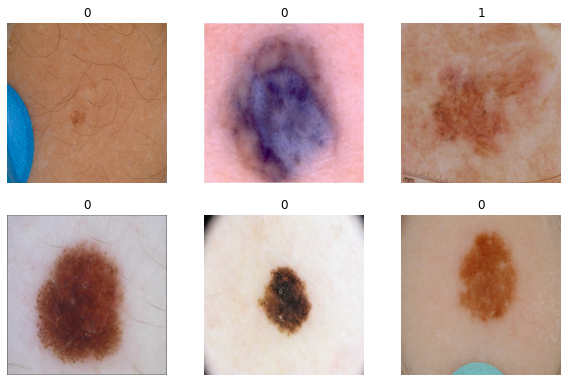

In [19]:
#A: visualise data, I'm not sure I understand how it knows which one is cancerous, not even sure if that's correct
#A: aren't the pictures deformed to fit a square?

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [20]:
#D: this doesn't work with my GPU - use CPU for this code
with tf.device('/cpu:0'):
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
        ]
    )

In [21]:
# plt.figure(figsize=(10, 10))
# for images, _ in data_set.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

In [22]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=img_size + (3,), num_classes=2)

In [23]:
# keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/5


In [ ]:
img = keras.preprocessing.image.load_img(
    "Data/Images/malignant/ISIC_0000004.jpeg", target_size=img_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent benign and %.2f percent malignant."
    % (100 * (1 - score), 100 * score)
)